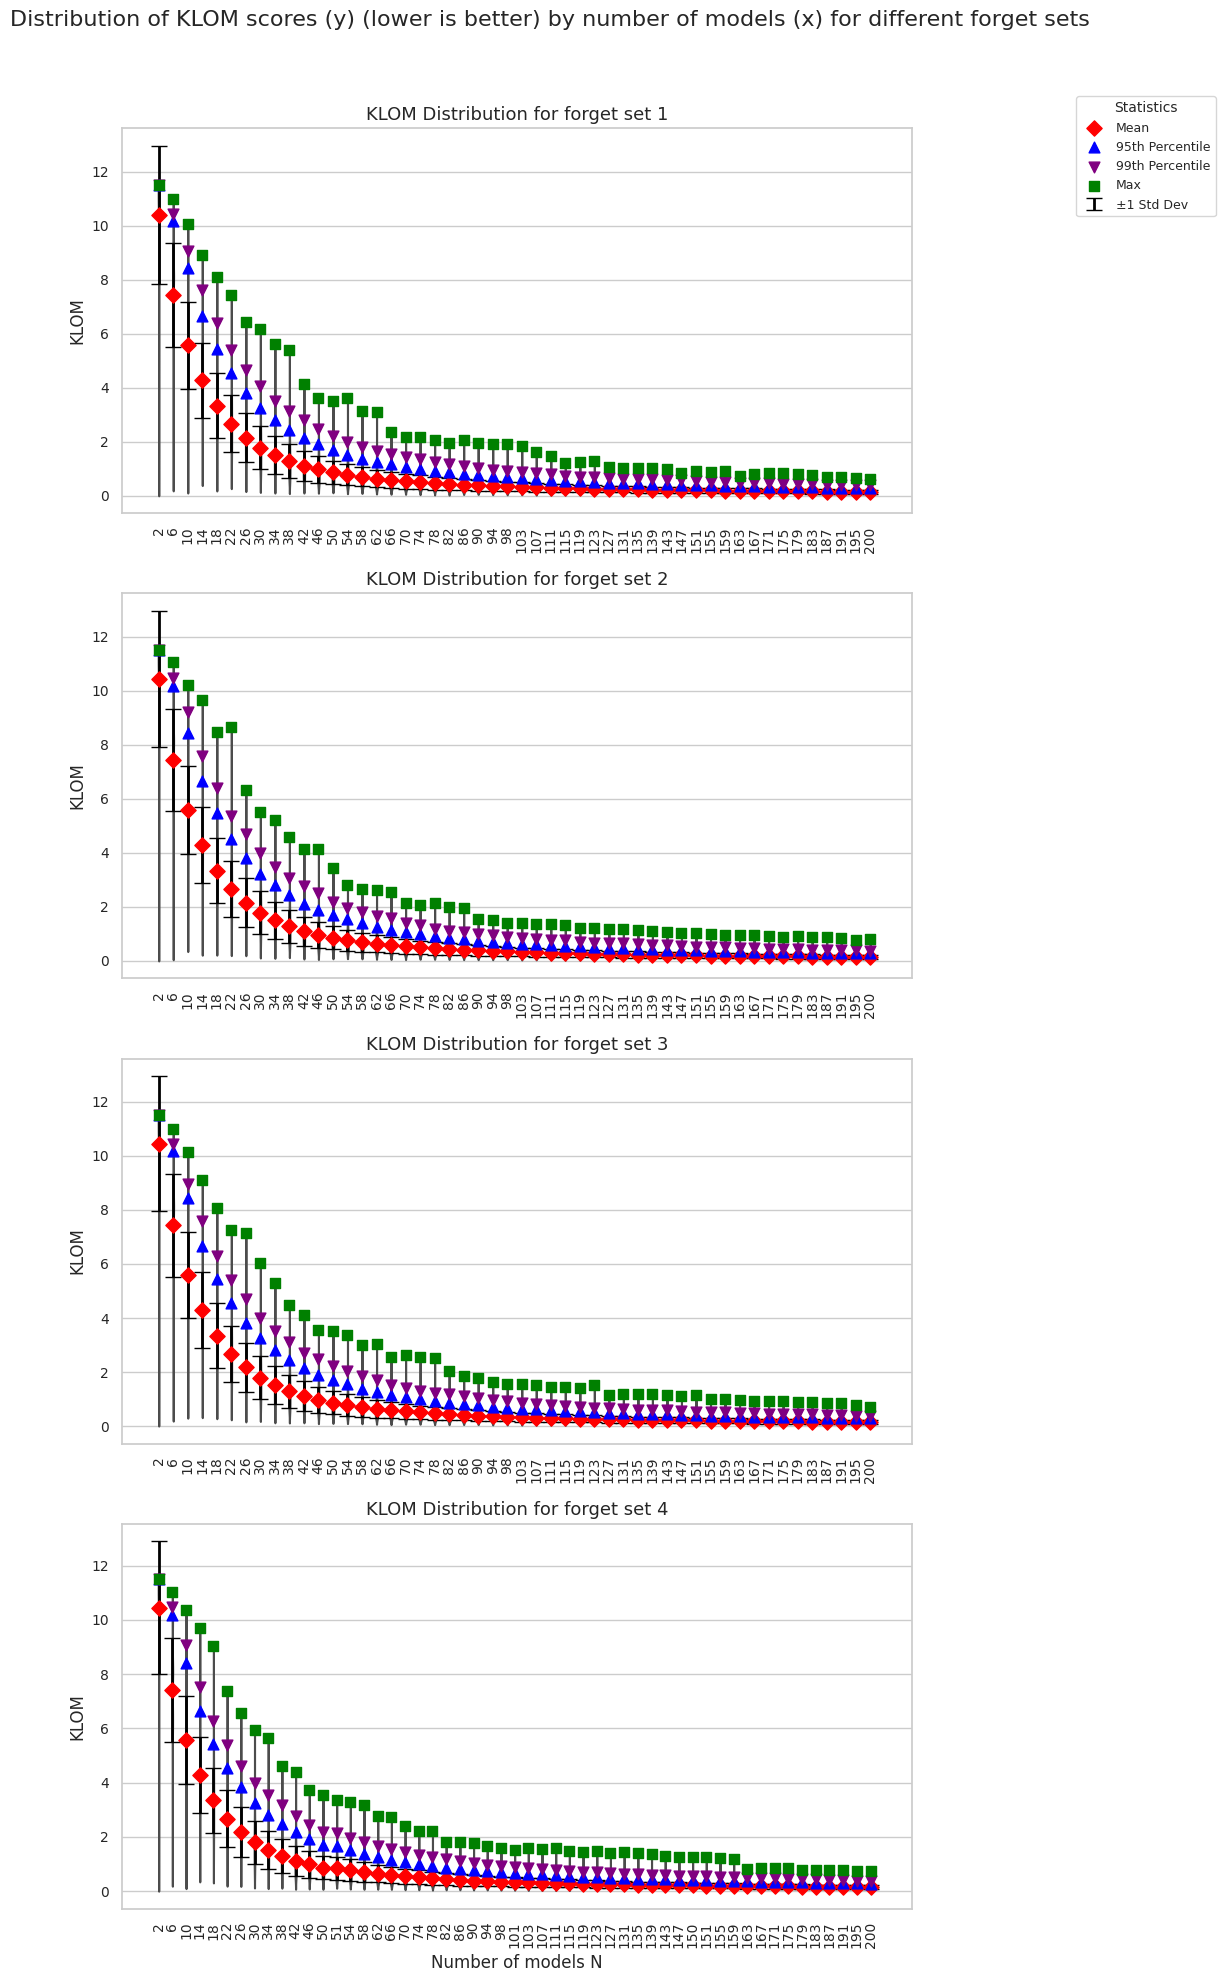

In [3]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

tmp_path = Path("./tmp")
values = {"N": [], "f": [], "values": []}

# load
for ff in tmp_path.iterdir():
    x = int(ff.name.split("_")[1])
    f = int(ff.name.split("f")[1].split(".")[0])
    arr = np.load(ff)
    values["N"].append(x)
    values["f"].append(f)
    values["values"].append(arr)

# explode
plot_data = []
for N, f, arr in zip(values["N"], values["f"], values["values"]):
    if isinstance(arr, np.ndarray) and arr.size:
        for v in arr:
            plot_data.append({"N": N, "f": f, "value": v})
    else:
        print(f"Warning: skipping N={N}, f={f}")

if not plot_data:
    raise RuntimeError("No data to plot")

df = pd.DataFrame(plot_data)
unique_fs = sorted(df["f"].unique())

# aggregated stats
agg = (
    df.groupby(["f","N"])["value"]
      .agg(mean="mean", std="std",
           p95=lambda x: np.percentile(x,95),
           p99=lambda x: np.percentile(x,99),
           max="max")  # Add max here
      .reset_index()
)

# setup subplots with independent x-axes
fig, axes = plt.subplots(len(unique_fs), 1,
                         figsize=(10, 5*len(unique_fs)),
                         sharex=False, squeeze=False)
sns.set_theme(style="whitegrid")

legend_added = False

for i, fval in enumerate(unique_fs):
    ax = axes[i,0]
    sub = df[df["f"]==fval].sort_values("N")
    stats = agg[agg["f"]==fval]
    Ns = sorted(sub["N"].unique())
    pos_map = {n: idx for idx, n in enumerate(Ns)}

    if sub.empty:
        ax.set_visible(False)
        continue

    # violin
    sns.violinplot(x="N", y="value", data=sub, ax=ax,
                   inner=None, linewidth=1.5, cut=0)

    # stats markers
    for _, row in stats.iterrows():
        pos = pos_map[row["N"]]
        m, s, p95, p99, mx = row[["mean","std","p95","p99", "max"]] # Add max here

        if not legend_added:
            ax.scatter(pos, m, marker="D", color="red",    s=60, label="Mean",           zorder=4)
            ax.scatter(pos, p95, marker="^", color="blue",  s=60, label="95th Percentile", zorder=4)
            ax.scatter(pos, p99, marker="v", color="purple",s=60, label="99th Percentile", zorder=4)
            ax.scatter(pos, mx, marker="s", color="green", s=60, label="Max",            zorder=4) # Add max marker
            ax.errorbar(pos, m, yerr=s, fmt="none",
                        ecolor="black", elinewidth=2, capsize=6,
                        label="±1 Std Dev", zorder=3)
            legend_added = True
        else:
            ax.scatter(pos, m, marker="D", color="red",    s=60, zorder=4)
            ax.scatter(pos, p95, marker="^", color="blue",  s=60, zorder=4)
            ax.scatter(pos, p99, marker="v", color="purple",s=60, zorder=4)
            ax.scatter(pos, mx, marker="s", color="green", s=60, zorder=4) # Add max marker
            ax.errorbar(pos, m, yerr=s, fmt="none",
                        ecolor="black", elinewidth=2, capsize=6, zorder=3)

    # cosmetics
    ax.set_title(f"KLOM Distribution for forget set {fval}", fontsize=13)
    ax.set_ylabel("KLOM")
    ax.set_xticks(range(len(Ns)))
    ax.set_xticklabels(Ns, rotation=90)
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    if i == len(unique_fs)-1:
        ax.set_xlabel("Number of models N")
    else:
        ax.set_xlabel("")

# legend & layout
if legend_added:
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels,
               bbox_to_anchor=(1.02, 0.95),
               loc="upper left", title="Statistics",
               fontsize=9, title_fontsize=10)

fig.suptitle("Distribution of KLOM scores (y) (lower is better) by number of models (x) for different forget sets", fontsize=16, y=0.99)
plt.tight_layout(rect=[0,0,0.88,0.97])
plt.show()